In [1]:
import cirq
import numpy as np
import matplotlib.pyplot as plt
from cirq.contrib.svg import SVGCircuit

In [2]:
def bitstring(bits):
    return ''.join('1' if e else '_' for e in bits)

def init_qubits(x_bin, *qubits):
    for x, q in zip(x_bin, list(qubits)[::-1]):
        if x == '1':
            yield cirq.X(q)

def display(result, circuit, bit_string =True):
    print("\n\nCircuit:")
    print(circuit)

    x1 = np.array(result.measurements['x1'][:, 0])
    x2 = np.array(result.measurements['x2'][:, 0])
    c_in = np.array(result.measurements['ci'][:, 0])

    s = np.array(result.measurements['sum'][:, 0])
    c_out = np.array(result.measurements['carry_out'][:, 0])
    
    if bit_string:
        x1 = bitstring(x1)
        x2 = bitstring(x2)
        c_in = bitstring(c_in)
        s = bitstring(s)
        c_out = bitstring(c_out)

    print("\n\nResults:")
    print('x1:', x1)
    print('x2:', x2)
    print('carry_in:', c_in)
    print('sum:', s)
    print('carry_out:', c_out)

In [3]:
def half_adder_deterministic(x):
    qubits = cirq.LineQubit.range(3)
    circuit = cirq.Circuit()

    # initialize bits
    x_bin = '{:08b}'.format(x)[-2:]
    circuit.append([init_qubits(x_bin, *qubits[:2])])

    circuit.append(half_adder_circuit(*qubits))
    
    return circuit

def half_adder_random():
    qubits = cirq.LineQubit.range(3)
    circuit = cirq.Circuit()

    # initialize bits
    circuit.append([cirq.H(qubits[0]), cirq.H(qubits[1])])

    circuit.append(half_adder_circuit(*qubits))
    
    return circuit

def half_adder_circuit(*qubits):
    
    # measure inputs
    m0 = cirq.Moment([cirq.measure(qubits[0], key='x1'),
                      cirq.measure(qubits[1], key='x2'),
                      cirq.measure(qubits[2], key='ci')])

    # adder circuit
    m1 = cirq.Moment([cirq.TOFFOLI(qubits[0], qubits[1], qubits[2])])
    m2 = cirq.Moment([cirq.CNOT(qubits[0], qubits[1])])

    # measure outputs
    m3 = cirq.Moment([cirq.measure(qubits[1], key='sum'),
                      cirq.measure(qubits[2], key='carry_out')])
    
    return (m0, m1, m2, m3)

In [4]:
for i in range(4):
    simulator = cirq.Simulator()
    circuit = half_adder_deterministic(i)
    result = simulator.run(circuit, repetitions=5)
    display(result, circuit, False)



Circuit:
0: ───M('x1')───@───@────────────────────
                │   │
1: ───M('x2')───@───X───M('sum')─────────
                │
2: ───M('ci')───X───────M('carry_out')───


Results:
x1: [0 0 0 0 0]
x2: [0 0 0 0 0]
carry_in: [0 0 0 0 0]
sum: [0 0 0 0 0]
carry_out: [0 0 0 0 0]


Circuit:
0: ───X───M('x1')───@───@────────────────────
                    │   │
1: ───────M('x2')───@───X───M('sum')─────────
                    │
2: ───────M('ci')───X───────M('carry_out')───


Results:
x1: [1 1 1 1 1]
x2: [0 0 0 0 0]
carry_in: [0 0 0 0 0]
sum: [1 1 1 1 1]
carry_out: [0 0 0 0 0]


Circuit:
0: ───────M('x1')───@───@────────────────────
                    │   │
1: ───X───M('x2')───@───X───M('sum')─────────
                    │
2: ───────M('ci')───X───────M('carry_out')───


Results:
x1: [0 0 0 0 0]
x2: [1 1 1 1 1]
carry_in: [0 0 0 0 0]
sum: [1 1 1 1 1]
carry_out: [0 0 0 0 0]


Circuit:
0: ───X───M('x1')───@───@────────────────────
                    │   │
1: ───X───M('x2')───@───X───M('



Circuit:
0: ───H───M('x1')───@───@────────────────────
                    │   │
1: ───H───M('x2')───@───X───M('sum')─────────
                    │
2: ───────M('ci')───X───────M('carry_out')───


Results:
x1: [0 0 0 0 0 0 1 0 1 0]
x2: [0 0 1 1 0 1 1 1 0 0]
carry_in: [0 0 0 0 0 0 0 0 0 0]
sum: [0 0 1 1 0 1 0 1 1 0]
carry_out: [0 0 0 0 0 0 1 0 0 0]





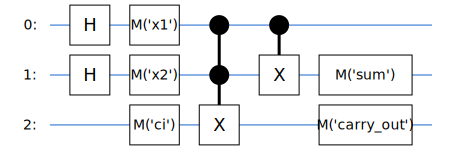

In [5]:
reps = 10
simulator = cirq.Simulator()
circuit = half_adder_random()
result = simulator.run(circuit, repetitions=reps)

display(result, circuit, False)
print("\n\n")
SVGCircuit(circuit)

In [6]:
x1 = np.array(result.measurements['x1'][:, 0])
x2 = np.array(result.measurements['x2'][:, 0])
c_in = np.array(result.measurements['ci'][:, 0])

s = np.array(result.measurements['sum'][:, 0])
c_out = np.array(result.measurements['carry_out'][:, 0])

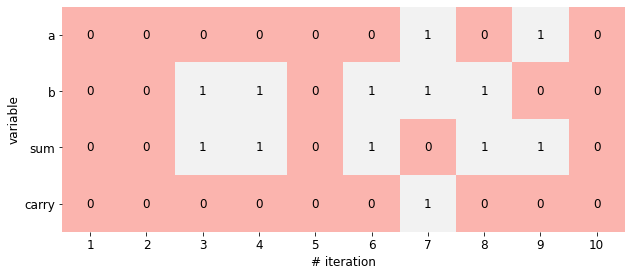

In [7]:
res = np.vstack([x1, x2, s, c_out])

plt.rcParams["figure.figsize"] = (16,4)
plt.rcParams["font.size"] = 12
fig, ax = plt.subplots()

im = ax.imshow(res, cmap='Pastel1')

ax.set_xticks(np.arange(reps))
ax.set_yticks(np.arange(4))

ax.set_xticklabels([str(x) for x in range(1, reps + 1)])
ax.set_yticklabels(['a', 'b', 'sum', 'carry'])

ax.set_xlabel('# iteration')
ax.set_ylabel('variable')

for i in range(4):
    for j in range(reps):
        text = ax.text(j, i, res[i, j],
                       ha="center", va="center", color="0")

for edge, spine in ax.spines.items():
    spine.set_visible(False)

fig.tight_layout()